# Кейс №2 - Приложение доставки

Вы работаете аналитиком в приложении по доставке продуктов. Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Ваша задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

В данных вы найдете логи заказов пользователей:

ab_users_data – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи

ab_orders – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ

ab_products – подробная информация о продуктах, их название и стоимость

_______________________________________________________________________________________________________________________________

Для начала подгрузим необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import pingouin as pg
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st
import requests
from urllib.parse import urlencode

In [3]:
# Считаем файл
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key_products = 'https://disk.yandex.ru/d/atwrlmB_wu-fHA' # ссылка на файл ab_products.csv
public_key_orders = 'https://disk.yandex.ru/d/prdO8FDQx7lzCg' # ссылка на файл ab_orders.csv
public_key_users_data = 'https://disk.yandex.ru/d/4qY27tJ23G_B1g' # ссылка на файл ab_users_data.csv

# Получаем загрузочные ссылки
final_url_products = base_url + urlencode(dict(public_key=public_key_products))
response_products = requests.get(final_url_products)
download_url_products = response_products.json()['href']

final_url_orders = base_url + urlencode(dict(public_key=public_key_orders))
response_orders = requests.get(final_url_orders)
download_url_orders = response_orders.json()['href']

final_url_users_data = base_url + urlencode(dict(public_key=public_key_users_data))
response_users_data = requests.get(final_url_users_data)
download_url_users_data = response_users_data.json()['href']


In [4]:
products = pd.read_csv(download_url_products) # считываем данные о продуктах, их название и стоимость
orders = pd.read_csv(download_url_orders) # считываем данные о составе заказа, 
# тут для каждого заказа есть список id тех продуктов, которые были включены в заказ
users_data = pd.read_csv(download_url_users_data) # считываем данные о история заказов пользователей, 
# в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи

## Проверим, изменилось ли число заказов на пользователя

In [15]:
users_data.head()

,user_id,order_id,action,time,date,group,is_cancelled
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,0
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,1
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,0


In [16]:
users_data.action.unique() # проверим данные в колонке состояния заказа

array(['create_order'], dtype=object)

In [17]:
canceled_orders = users_data.query('action == "cancel_order"').order_id # отсеим серию отмененных заказов

In [18]:
users_data['is_cancelled'] = users_data['order_id'].isin(canceled_orders).astype(int) # создаем переменную отмены заказа,
# где 0 - не отменен, 1 - отменен
users_data

,user_id,order_id,action,time,date,group,is_cancelled
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,0
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,0
...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1,0
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1,0
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0,0
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0,0


In [20]:
users_data = users_data.query('action == "create_order"') # отбираем необходимые заказы
users_data.head()

,user_id,order_id,action,time,date,group,is_cancelled
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,0
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,0


In [21]:
order_per_user = users_data.groupby(['group', 'user_id'], as_index=False).size()
order_per_user.head() # сгруппируем данные по группам и id пользователей и посчитаем кол-во заказов на пользователя

,group,user_id,size
0,0,964,2
1,0,966,1
2,0,968,3
3,0,969,2
4,0,972,1


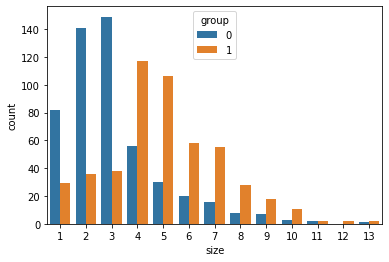

In [22]:
sns.countplot(data=order_per_user, x='size', hue='group') # визуализируем данные с прошлого шага и увидим распределение заказов
# по группам

In [25]:
pg.ttest(x = order_per_user.query('group == 0')['size'], y = order_per_user.query('group == 1')['size']) # проведем т-тест и
# исходя из него видим, что p-value < 0.05, а значит наблюдаем статистически значимые различия, в среднем пользователи из
# тестовой группы стали заказывать на 2 заказа больше

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-14.485157,988.435475,two-sided,2.907783e-43,"[-2.14, -1.63]",0.910119,7.663e+39,1.0


## Изменилась ли пропорция отмен

In [27]:
pd.crosstab(users_data.group, users_data.is_cancelled) # посмотрим на кросстабуляцию групп и отмененных заказов

is_cancelled,0
group,
0,1609
1,2514


In [28]:
# Т.к. у нас переменные категориальные, проведем тест хи-квадрат
exp, obs, stats = pg.chi2_independence(data=users_data, x='group', y='is_cancelled')
stats # в результате теста видим, что p-value > 0.05, а значит нулевую гипотезу не можем отклонить, пропорция отмен не
# изменилась, а их количество отмен связано с тем, что больше самих заказов

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.0,0.0,1.0,NaN,NaN
1,cressie-read,0.666667,0.0,0.0,1.0,NaN,NaN
2,log-likelihood,0.000000,0.0,0.0,1.0,NaN,NaN
3,freeman-tukey,-0.500000,0.0,0.0,1.0,NaN,NaN
4,mod-log-likelihood,-1.000000,0.0,0.0,1.0,NaN,NaN
5,neyman,-2.000000,0.0,0.0,1.0,NaN,NaN


## Изменилось ли число позиций в заказе

In [29]:
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [30]:
orders_and_users = users_data.merge(orders, on='order_id', how='inner') # объединим данные о заказах и пользователях
orders_and_users.head()

,user_id,order_id,action,time,date,group,is_cancelled,creation_time,product_ids
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,0,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,0,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,0,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,0,2022-08-26 00:02:56.000000,"{74, 6}"
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,0,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [31]:
orders_and_users['product_ids'] = orders_and_users['product_ids'].str.strip('{}').str.split(', ') # преобразуем колонку product_ids
orders_and_users_expl = orders_and_users.explode('product_ids') # с помощью метода explode разделим  id продуктов
orders_and_users_expl.head()

,user_id,order_id,action,time,date,group,is_cancelled,creation_time,product_ids
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,0,2022-08-26 00:00:19.000000,75
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,0,2022-08-26 00:00:19.000000,22
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,0,2022-08-26 00:00:19.000000,53
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,0,2022-08-26 00:00:19.000000,84
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,0,2022-08-26 00:02:21.000000,56


In [32]:
product_count = orders_and_users_expl.groupby(['group', 'order_id'], as_index=False).size()
product_count # сгруппируем данные по группам и id заказа

,group,order_id,size
0,0,1255,4
1,0,1257,4
2,0,1258,2
3,0,1261,4
4,0,1262,4
...,...,...,...
4118,1,59220,4
4119,1,59250,3
4120,1,59390,5
4121,1,59422,3


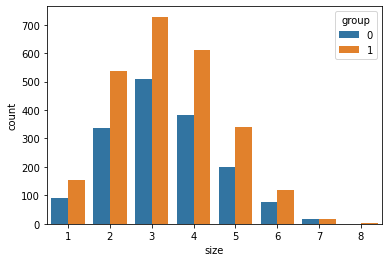

In [33]:
sns.countplot(data=product_count, x='size', hue='group') # визуализируем предыдущий шаг и видим, что распределение кол-ва
# заказов в группах особо не отличается

In [34]:
pg.ttest(x=product_count.query('group == 0')['size'], y=product_count.query('group == 1')['size']) # проведем т-тест,
# в результате получаем, что p-value > 0.05, а значит статистических различий нет

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.138556,3469.224056,two-sided,0.889809,"[-0.09, 0.07]",0.004407,0.036,0.052185


### Вывод: в результате тестов определили, что в среднем в тестовой группе пользователь стал заказывать на 2 заказа больше, чем ранее, в связи с увеличением заказов процент отмен не вырос, количество позиций в заказе в среднем не изменилось 